<a href="https://colab.research.google.com/github/sayan0506/Synthetic-Image-generation-using-VAE-/blob/main/Implement_VAE_using_Keras_backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules

Importing nercessary modules, here we will implement the VAE using the tensorflow backend from scratch

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
# from keras.layers import BatchNormalization
# importing keras functional api for neural network 
from tensorflow.keras.models import Model
# in latest keras the datasets are corrspond to keras, rather than previous tensorflow.examples.tutorial
from tensorflow.keras.datasets import mnist
# this keras backend will help to do some basic calculations or math stuffs
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model



In [2]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
# from keras.layers import BatchNormalization
# importing keras functional api for neural network 
from keras.models import Model
# in latest keras the datasets are corrspond to keras, rather than previous tensorflow.examples.tutorial
from keras.datasets import mnist
# this keras backend will help to do some basic calculations or math stuffs
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model


# Load MNIST

Loading the traina and test dataset of digits

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
print(f'Shape of the dataset: {x_train.shape}, {y_train.shape}, {x_test.shape}, {y_test.shape}')

Shape of the dataset: (60000, 28, 28), (60000,), (10000, 28, 28), (10000,)


# Data Pre-processing

## Normalizing the dataset

In [5]:
# as VAE is a autoencoder based network, no need of classification information
# so we will only deal with the images
# converting the pixels to float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalizing the dataset
x_train = x_train / 255.
x_test = x_test / 255.

## Reshaping the dataset

In [6]:
# reshape the data
num_channels = 1
# reshaping the images to 4 dimensional space shape = (m, width, height, channels)
# skipped 1st 3 dimensions and adding new axis where we add channel axis
# for grayscale image channel = 1
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

# shape after reshaping
print(f'Reshaped size: {x_train.shape}, {x_test.shape}')

Reshaped size: (60000, 28, 28, 1), (10000, 28, 28, 1)


# Data Visualization

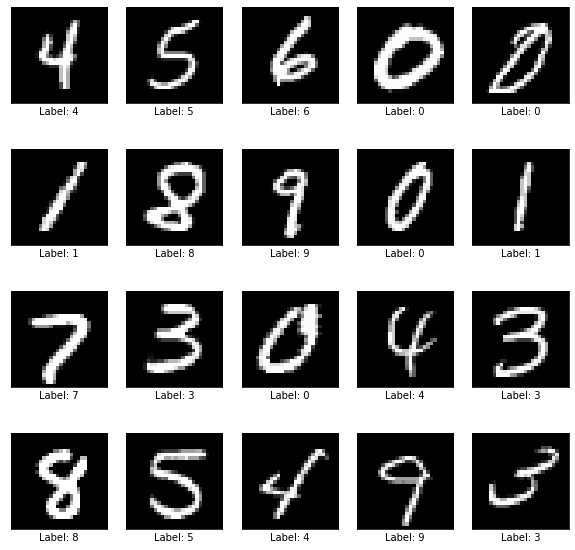

In [7]:
# let ius visualzie 20 random sample training images

# rows = 4
r = 4
# columns = 5
c = 5

fig = plt.figure(figsize=(10,10))

for i in range(r * c):
  fig.add_subplot(r, c, i + 1)
  # random image no
  img_id = np.random.randint(0, x_train.shape[0])
  # np.squeeze the all unimportant dimensions, here m = 1, c = 1 for single image
  plt.imshow(np.squeeze(x_train[img_id]), cmap = 'gray')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f'Label: {y_train[img_id]}')
  # plt.axis('off')

fig.show()

## Defining the parameters

In [8]:
# definingthe input image shape
img_width = x_train.shape[1]
img_height = x_train.shape[2]
input_img_shape = (img_width, img_height, num_channels)
 
# latent space dimension considered to be 2D here
latent_dim = 2

# Building the Computational Graph of the Variational Autoencoder

* The variational autoencoder consists of encoder + latent_space + decoder
* The latent space consists of the combination of mean(mu) + std(sigma) layer
* We will use keras **Functional API** for the network

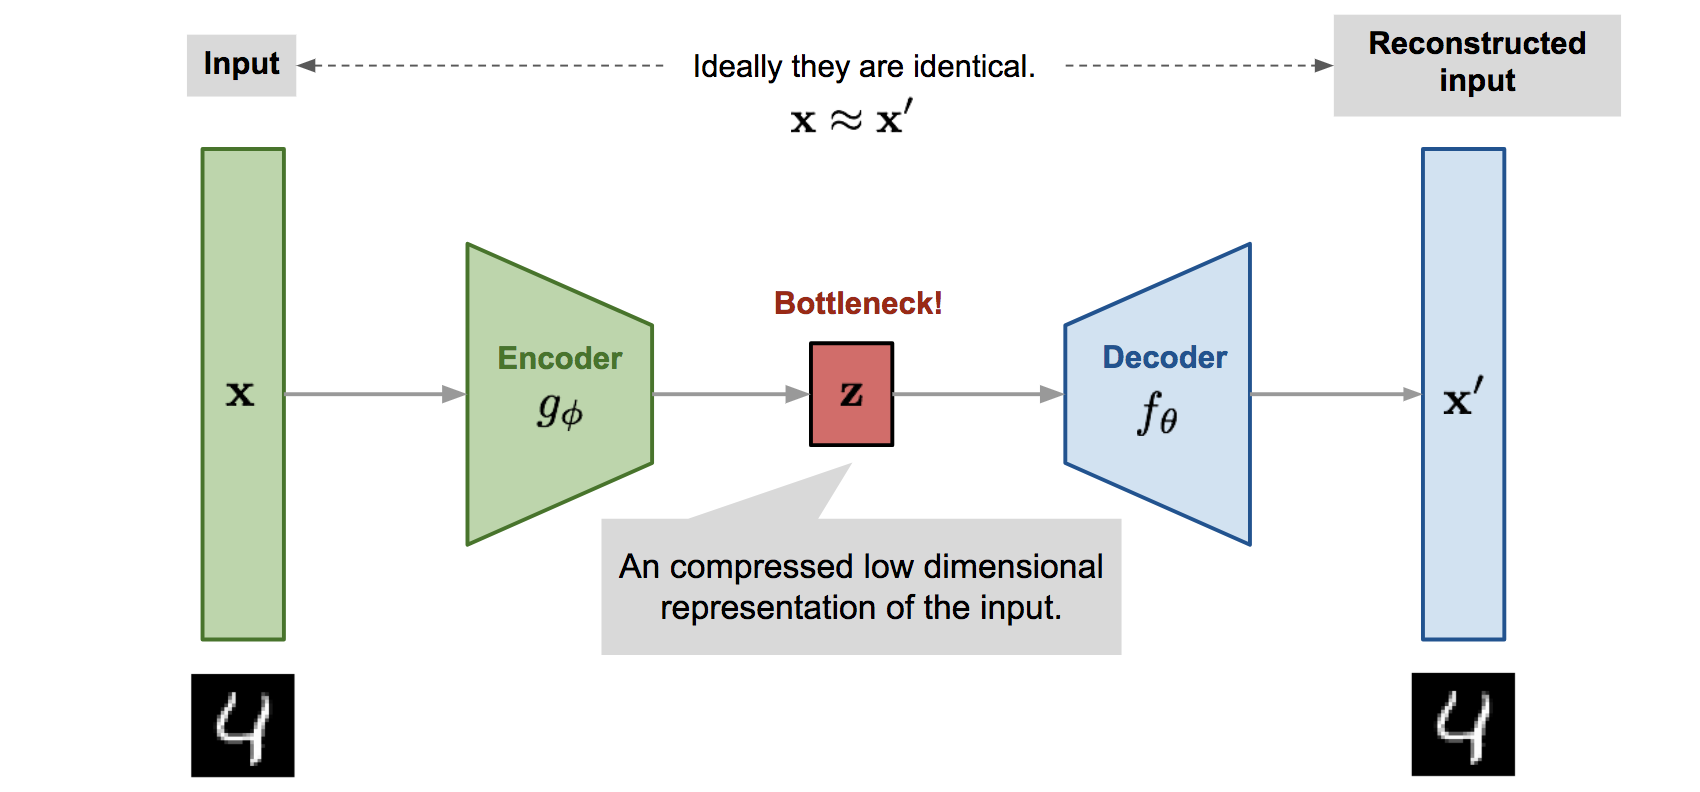

[image_link](https://www.google.com/url?sa=i&url=https%3A%2F%2Flilianweng.github.io%2Flil-log%2F2018%2F08%2F12%2Ffrom-autoencoder-to-beta-vae.html&psig=AOvVaw3-6qbk7x5xUZtop7SEl2sO&ust=1610287747220000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCKjrmZ-Dj-4CFQAAAAAdAAAAABAJ)

## Encoder section

* The encoder consists of 4 conv2d
* Then, the output is fed to a Flatten layer, then to a dense layer

In [9]:
# encoder convolution section
input_img = Input(shape = input_img_shape, name = 'VAE_encoder_input')
x = Conv2D(filters = 32, kernel_size= 3, padding='same', activation= 'relu')(input_img)
x = Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu', strides = (2,2))(x)
x = Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu')(x)
x = Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu')(x)
                                                                                                                                                                                                                                                                                         
# As decoder reconstructs the image, so 1st convolution of decoder willbe transpose and having same shape as the 4th Conv2D
# shape of cnv2 to be provided to the decoder
conv_shape = K.int_shape(x)

# Flatten 
x = Flatten()(x)
# dense layer
x = Dense(32, activation = 'relu')(x)

# **Reparameterization Trick**

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_encoder_input (InputLayer)  [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         VAE_encoder_input[0][0]          
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

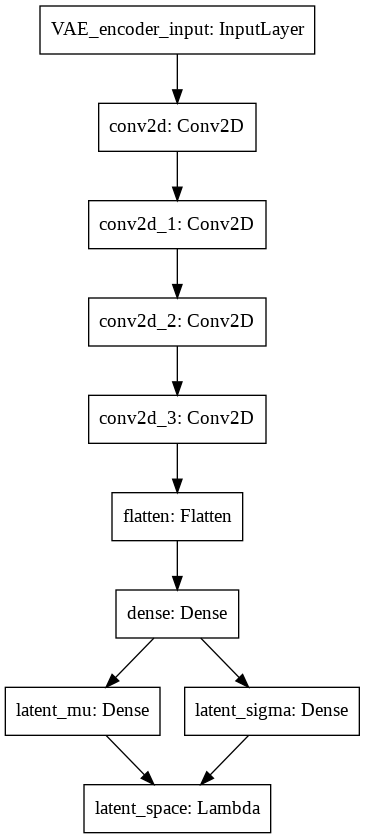

In [10]:
# mean layer
mean_layer = Dense(latent_dim, name = "latent_mu")(x)

# standard deviation hidden layer
std_layer = Dense(latent_dim, name = "latent_sigma")(x)

# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma * eps
# this is to allow gradient descent to estimate the gradients properly, or this helps to to make the z node from random to deterministic
# because we can't apply gradients on the stochastic node
def sample_z(args):
  z_mu, z_sigma = args
  # random samples from a normal distribution or a distribution we choose that the latent space should maintain
  epsilon = K.random_normal(shape = (K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  # reparameterized z
  latent_z = z_mu + K.exp(1/2 * z_sigma) * epsilon
  return latent_z

# now in lambda latent layer we need to add the gradient descent calculation
# using mu and variance(sigma)
# in Lambda layer we pass the function_name
z = Lambda(sample_z, output_shape = (latent_dim, ), name = 'latent_space')([mean_layer, std_layer])

# Define and summarize the Encoder Model
encoder = Model(input_img, [mean_layer, std_layer, z], name = 'encoder')
# Model summary
encoder.summary()
# plotting the model
plot_model(encoder)

## Decoder *Section*

In [11]:
print(conv_shape)

(None, 14, 14, 64)


(None, 14, 14, 64)
(None, 28, 28, 32)
(None, 28, 28, 1)
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


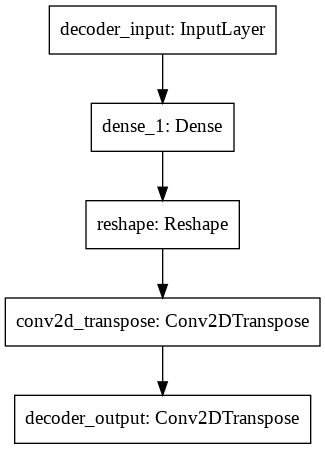

In [12]:
# decoder takes the latent vector as input
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')

# we need the output from decoder_layer_1 will be same as the conv2D_4 input
# so add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshaping the output to feed to the conv2d layer in the decoder
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale back to original shape 
print(x.shape)
x = Conv2DTranspose(32, 3, padding = 'same', activation = 'relu', strides = (2,2))(x)
print(x.shape)
# returning back to recostructed image
x = Conv2DTranspose(num_channels, 3, padding = 'same', activation = 'sigmoid', name = 'decoder_output')(x)
print(x.shape)

# defining the decoder model using the functional api
decoder = Model(decoder_input, x, name = 'decoder')
decoder.summary()
plot_model(decoder)

We set the decoder layer 1 as input layer, the input layer receives the latent space layer as input attribute by defining the object of the decoder model using the keras functional api.

In [13]:
# apply the decoder to latent sample
print(z.shape)

z_decoded = decoder(z)
print(z_decoded.shape)
print(x)
print(z_decoded)

(None, 2)
(None, 28, 28, 1)
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), name='decoder_output/Sigmoid:0', description="created by layer 'decoder_output'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), name='decoder/decoder_output/Sigmoid:0', description="created by layer 'decoder'")


# Defining the loss of the VAE

We know, **variational lower bound = Reconstructional loss or log-likelihood or data-fidelity_loss term + KL divergence term or the regularizer**

Note: **Why we used model.add_loss?**

For your VAE example this is the case because the loss function also depends on additional tensors, namely z_log_var and z_mean, which are not available to the loss functions. Using model.add_loss() has no such restriction and allows you to write much more complex losses that depend on many other tensors, but it has the inconvenience of being more dependent on the model, whereas the standard loss functions work with just any model.

[link](https://stackoverflow.com/questions/50063613/what-is-the-purpose-of-the-add-loss-function-in-keras)

In [14]:
import tensorflow

# Define the custom loss
# VAE is trained using two loss functions reconstruction loss and KL divergence regulazrizer
# let us define a custom layer class using keras layer class api

class CustomLayer(keras.layers.Layer):
  
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)

    # reconstruction loss, (as we are using sigmoid, we can us binry cross-entropy)
    recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    print(recon_loss.shape)
    # KL-divergence loss
    # K.mean implies mean across the variables of the latent space
    # axis = -1, as we are taking mean across the dimension of latent space, whose index is -1
    kl_loss = - 5e-4 * K.mean(1 + std_layer - K.square(mean_layer) - K.exp(std_layer), axis = -1)
    print(kl_loss.shape)
    return K.mean(recon_loss + kl_loss)

  # add custom loss to the class
  # here we calling call function, at in python if the function name is call, it becomes callable with the instance of the class
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    # using the model.add_loss or here as it inherited to keras.layer.Layer class, so self.add_loss acts as model.add_loss
    # which helps to define any complex loss function also dependent on other parameters of the model apart from only y_true and y_pred
    self.add_loss(loss, inputs = inputs)
    return x


In [15]:
print(input_img)
print(encoder.input)
print(z_decoded)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='VAE_encoder_input'), name='VAE_encoder_input', description="created by layer 'VAE_encoder_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='VAE_encoder_input'), name='VAE_encoder_input', description="created by layer 'VAE_encoder_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), name='decoder/decoder_output/Sigmoid:0', description="created by layer 'decoder'")


# Applying the custom loss to input images and decoded latent distribution sample

()
(None,)
Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_encoder_input (InputLayer)  [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         VAE_encoder_input[0][0]          
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
_____________________________________________________________________________________

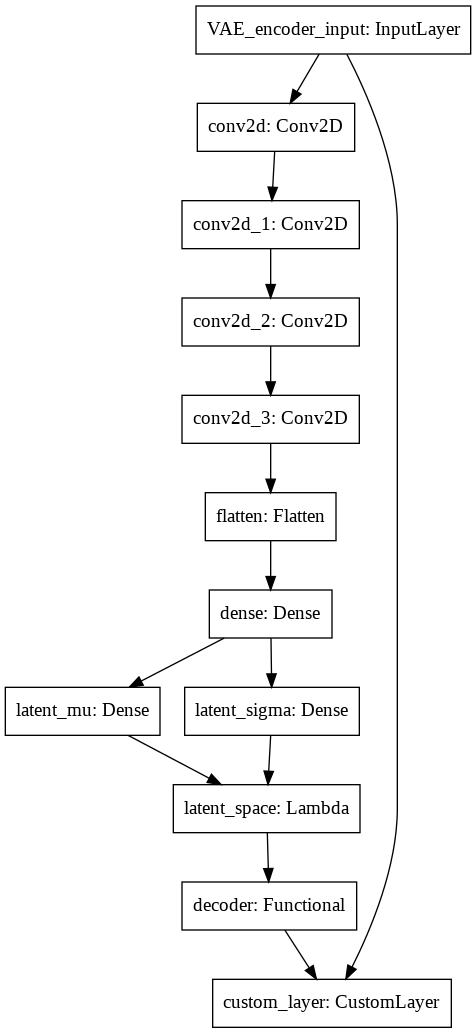

In [16]:
# here reconstruction loss is calculated between input_img and reconstructed por decoded image
y = CustomLayer()([input_img, z_decoded])
# y is the reconstructed image from the decoder

# VAE
vae = Model(input_img, y, name = 'VAE')
vae.summary()
plot_model(vae)

# Without using Loss Custom Layer

In [77]:
import tensorflow as tf

def vae_loss(x, z_decoded):
  x = K.flatten(x)
  z_decoded = K.flatten(z_decoded)

  # reconstruction loss, (as we are using sigmoid, we can us binry cross-entropy)
  recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

  # KL-divergence loss
  # K.mean implies mean across the variables of the latent space
  # axis = -1, as we are taking mean across the dimension of latent space, whose index is -1
  kl_loss = -5 * K.mean(1 + std_layer - K.square(mean_layer) - K.exp(std_layer), axis = -1)
  return K.mean(recon_loss + kl_loss)

'''
x = K.flatten(input_img)
z_decoded = K.flatten(z_decoded)
reconstruction_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)
reconstruction_loss *= original_dim
kl_loss = 1 + std_layer - K.square(mean_layer) - K.exp(std_layer)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
'''

# obtaining the variational lower bound
loss = vae_loss(input_img, z_decoded)
#print(loss.shape)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_encoder_input (InputLayer)  [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         VAE_encoder_input[0][0]          
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_5[0][0]                   
________________________________________________________________________________________________

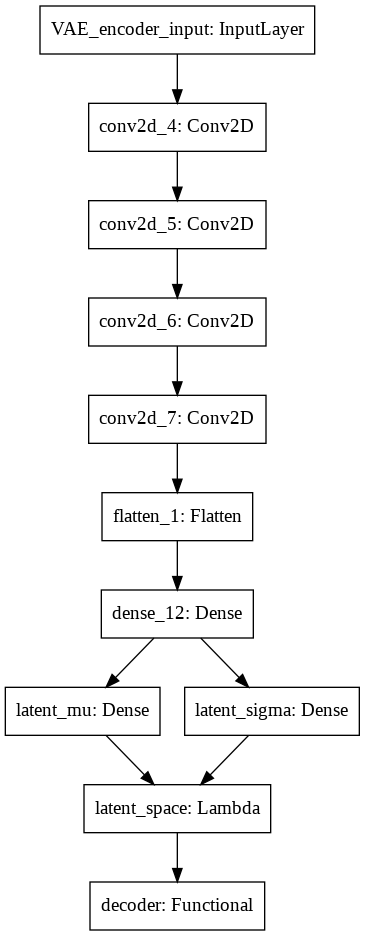

In [78]:
# VAE
vae = Model(input_img, z_decoded, name = 'VAE')
vae.summary()
plot_model(vae)

In [79]:
vae.add_loss(loss)

# Model Compile and Training

In [17]:
# compile vae
vae.compile(optimizer = 'adam', loss = None)

# defining the training parameters
epochs = 50
batch_size = 32
validation_split = 0.2

# training the model 
vae.fit(x_train, None, epochs = epochs, batch_size = batch_size, validation_split = validation_split)

Epoch 1/50
()
(None,)


TypeError: ignored

In [81]:
mu, _, _ = encoder.predict(x_test)
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [157]:
print(keras.__version__)

2.4.3


In [158]:
import keras
from keras import layers

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [159]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [160]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [161]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [162]:
print(vae_loss)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean_64/Mean:0', description="created by layer 'tf.math.reduce_mean_64'")


In [163]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 5s 3ms/step - loss: 220.8810 - val_loss: 166.5232
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 165.5744 - val_loss: 163.1210
Epoch 3/100
1875/1875 [==============================] - 5s 2ms/step - loss: 162.1708 - val_loss: 160.5728
Epoch 4/100
1875/1875 [==============================] - 5s 2ms/step - loss: 159.9376 - val_loss: 158.6396
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 158.0657 - val_loss: 157.2182
Epoch 6/100
1875/1875 [==============================] - 5s 2ms/step - loss: 157.0684 - val_loss: 155.9994
Epoch 7/100
1875/1875 [==============================] - 5s 2ms/step - loss: 155.5995 - val_loss: 154.8331
Epoch 8/100
1875/1875 [==============================] - 5s 2ms/step - loss: 154.3603 - val_loss: 154.1178
Epoch 9/100
1875/1875 [==============================] - 5s 2ms/step - loss: 153.5979 - val_loss: 153.2800
Epoch 10/100
1875/1875 [=============

In [180]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,:,0], int(x_test_encoded[:,:,1]), c=y_test)
plt.colorbar()
plt.show()

TypeError: ignored

<Figure size 432x432 with 0 Axes>

In [176]:
len(x_test_encoded[0])

AttributeError: ignored

In [178]:
np.array(x_test_encoded).reshape(1000)

(3, 10000, 2)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 256)          200960      input_11[0][0]                   
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 2)            514         dense_29[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 2)            514         dense_29[0][0]                   
____________________________________________________________________________________________

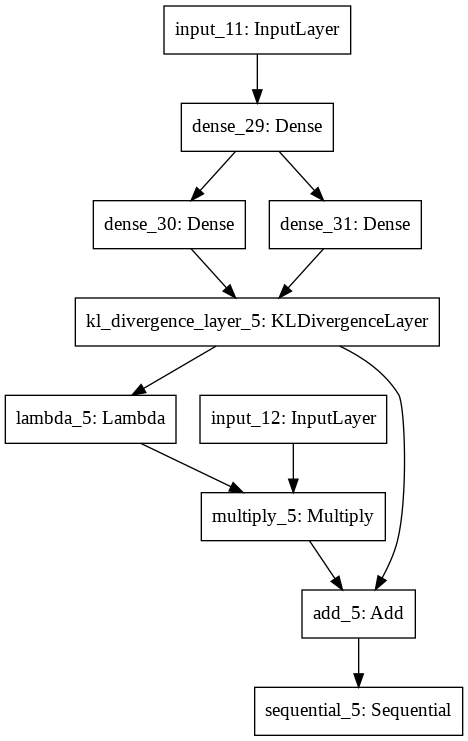

In [24]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0


def nll(y_true, y_pred):
  
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):
  
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.
vae.summary()
plot_model(vae)

In [25]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)
#validation_data=(x_test, x_test))

encoder = Model(x, z_mu)

z_test = encoder.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(20, 20))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.savefig('scatter.png')

n = 15 
digit_size = 28

u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(20, 20))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gnuplot2')
plt.savefig('mapped.png')

Epoch 1/50


ValueError: ignored